In [1]:
# Cell 1: Project Setup and Data Loading
import os
import librosa
import numpy as np
import pandas as pd
from pathlib import Path
import tensorflow as tf
import gc
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization
from tensorflow.keras.regularizers import l1, l2, l1_l2
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import warnings
warnings.filterwarnings('ignore')

print(f"TensorFlow version: {tf.__version__}")
print("Project: Dysarthric Speech Classification using Machine Learning Optimization Techniques")
print("=" * 80)

# Create directories for saving models
os.makedirs('saved_models', exist_ok=True)

# Define paths to your data
DYSARTHRIC_PATH = r"E:\school\Dysarthric_Speech_Classification\M_Dys\wav_arrayMic_M01S01"
CONTROL_PATH = r"E:\school\Dysarthric_Speech_Classification\M_Con\wav_arrayMic_MC01S01"

def get_file_list(directory):
    """Get list of wav files from directory"""
    if not os.path.exists(directory):
        print(f"Directory not found: {directory}")
        return []
    return [os.path.join(directory, f) for f in os.listdir(directory) if f.endswith('.wav')]

# Load file lists
dysarthric_files = get_file_list(DYSARTHRIC_PATH)
control_files = get_file_list(CONTROL_PATH)

print(f"Found {len(dysarthric_files)} dysarthric files")
print(f"Found {len(control_files)} control files")

# Use 50 files per class for the assignment
MAX_FILES_PER_CLASS = 50
dysarthric_files = dysarthric_files[:MAX_FILES_PER_CLASS]
control_files = control_files[:MAX_FILES_PER_CLASS]

# Create labels
all_files = dysarthric_files + control_files
all_labels = [1] * len(dysarthric_files) + [0] * len(control_files)

print(f"Dataset: {len(all_files)} total files ({len(dysarthric_files)} dysarthric, {len(control_files)} control)")

TensorFlow version: 2.19.0
Project: Dysarthric Speech Classification using Machine Learning Optimization Techniques
Found 100 dysarthric files
Found 329 control files
Dataset: 100 total files (50 dysarthric, 50 control)


In [2]:
# Cell 2: Feature Extraction Functions
def load_wav_16k_mono(filename):
    """Load a WAV file, convert to float tensor, resample to 16kHz mono"""
    audio, sr = librosa.load(filename, sr=16000, mono=True, duration=2.0)
    wav = tf.constant(audio, dtype=tf.float32)
    return wav

def extract_features_for_ml(file_path):
    """Extract traditional ML features from audio file"""
    try:
        # Load audio
        audio, sr = librosa.load(file_path, sr=16000, mono=True, duration=2.0)
        
        # Extract features
        features = []
        
        # MFCC features
        mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=13)
        features.extend(np.mean(mfccs, axis=1))
        features.extend(np.std(mfccs, axis=1))
        
        # Spectral features
        spectral_centroids = librosa.feature.spectral_centroid(y=audio, sr=sr)
        features.append(np.mean(spectral_centroids))
        features.append(np.std(spectral_centroids))
        
        # Zero crossing rate
        zcr = librosa.feature.zero_crossing_rate(audio)
        features.append(np.mean(zcr))
        features.append(np.std(zcr))
        
        # Chroma features
        chroma = librosa.feature.chroma_stft(y=audio, sr=sr)
        features.extend(np.mean(chroma, axis=1))
        
        return np.array(features)
    except Exception as e:
        print(f"Error extracting features from {file_path}: {e}")
        return np.zeros(40)  # Return zeros if error

def preprocess_audio_for_nn(file_path, label):
    """Convert audio to spectrogram for neural network"""
    wav = load_wav_16k_mono(file_path)
    
    # Fixed length (32000 samples = 2 seconds at 16kHz)
    if len(wav) > 32000:
        wav = wav[:32000]
    else:
        padding = 32000 - len(wav)
        wav = tf.concat([tf.zeros(padding, dtype=tf.float32), wav], 0)
    
    # Create spectrogram
    spectrogram = tf.signal.stft(wav, frame_length=512, frame_step=256)
    spectrogram = tf.abs(spectrogram)
    spectrogram = spectrogram[::2, ::2]  # Downsample
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    
    return spectrogram, label

print("Feature extraction functions defined successfully!")

Feature extraction functions defined successfully!


In [3]:
# Cell 3: Data Preparation
print("Preparing data for ML models...")

# Extract features for traditional ML algorithms
X_features = []
for file_path in all_files:
    features = extract_features_for_ml(file_path)
    X_features.append(features)

X_features = np.array(X_features)
y_labels = np.array(all_labels)

print(f"Feature matrix shape: {X_features.shape}")
print(f"Labels shape: {y_labels.shape}")

# Split data into train, validation, and test sets
X_temp, X_test, y_temp, y_test = train_test_split(
    X_features, y_labels, test_size=0.2, random_state=42, stratify=y_labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples") 
print(f"Test set: {X_test.shape[0]} samples")

# Scale features for ML algorithms
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Prepare file lists for neural network
files_temp, files_test, labels_temp, labels_test = train_test_split(
    all_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels
)

files_train, files_val, labels_train, labels_val = train_test_split(
    files_temp, labels_temp, test_size=0.25, random_state=42, stratify=labels_temp
)

print("Data preparation completed!")

Preparing data for ML models...


Feature matrix shape: (100, 42)
Labels shape: (100,)
Training set: 60 samples
Validation set: 20 samples
Test set: 20 samples
Data preparation completed!


In [4]:
# Cell 4: Model 1 - Classical ML (Logistic Regression with Hyperparameter Tuning)
print("Training Model 1: Optimized Logistic Regression")
print("=" * 50)

from sklearn.model_selection import GridSearchCV

# Hyperparameter tuning for Logistic Regression
param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear'],
    'max_iter': [1000]
}

# Grid search with cross-validation
lr_grid = GridSearchCV(
    LogisticRegression(random_state=42),
    param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

lr_grid.fit(X_train_scaled, y_train)

# Best model
best_lr = lr_grid.best_estimator_
print(f"Best parameters: {lr_grid.best_params_}")

# Train and evaluate
y_train_pred_lr = best_lr.predict(X_train_scaled)
y_val_pred_lr = best_lr.predict(X_val_scaled)
y_test_pred_lr = best_lr.predict(X_test_scaled)

# Calculate metrics
train_acc_lr = accuracy_score(y_train, y_train_pred_lr)
val_acc_lr = accuracy_score(y_val, y_val_pred_lr)
test_acc_lr = accuracy_score(y_test, y_test_pred_lr)

train_f1_lr = f1_score(y_train, y_train_pred_lr)
val_f1_lr = f1_score(y_val, y_val_pred_lr)
test_f1_lr = f1_score(y_test, y_test_pred_lr)

train_precision_lr = precision_score(y_train, y_train_pred_lr)
val_precision_lr = precision_score(y_val, y_val_pred_lr)
test_precision_lr = precision_score(y_test, y_test_pred_lr)

train_recall_lr = recall_score(y_train, y_train_pred_lr)
val_recall_lr = recall_score(y_val, y_val_pred_lr)
test_recall_lr = recall_score(y_test, y_test_pred_lr)

print(f"\nLogistic Regression Results:")
print(f"Training - Acc: {train_acc_lr:.3f}, F1: {train_f1_lr:.3f}, Precision: {train_precision_lr:.3f}, Recall: {train_recall_lr:.3f}")
print(f"Validation - Acc: {val_acc_lr:.3f}, F1: {val_f1_lr:.3f}, Precision: {val_precision_lr:.3f}, Recall: {val_recall_lr:.3f}")
print(f"Test - Acc: {test_acc_lr:.3f}, F1: {test_f1_lr:.3f}, Precision: {test_precision_lr:.3f}, Recall: {test_recall_lr:.3f}")

# Save model
import joblib
joblib.dump(best_lr, 'saved_models/optimized_logistic_regression.pkl')
print("Model saved as 'optimized_logistic_regression.pkl'")

Training Model 1: Optimized Logistic Regression
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}

Logistic Regression Results:
Training - Acc: 0.967, F1: 0.966, Precision: 1.000, Recall: 0.933
Validation - Acc: 1.000, F1: 1.000, Precision: 1.000, Recall: 1.000
Test - Acc: 0.850, F1: 0.824, Precision: 1.000, Recall: 0.700
Model saved as 'optimized_logistic_regression.pkl'
Best parameters: {'C': 0.1, 'max_iter': 1000, 'penalty': 'l1', 'solver': 'liblinear'}

Logistic Regression Results:
Training - Acc: 0.967, F1: 0.966, Precision: 1.000, Recall: 0.933
Validation - Acc: 1.000, F1: 1.000, Precision: 1.000, Recall: 1.000
Test - Acc: 0.850, F1: 0.824, Precision: 1.000, Recall: 0.700
Model saved as 'optimized_logistic_regression.pkl'


In [5]:
# Cell 5: Neural Network Data Generator
def create_dataset_generator(files, labels, batch_size=8):
    """Create dataset using generator for neural networks"""
    
    def data_generator():
        for file_path, label in zip(files, labels):
            try:
                spectrogram, processed_label = preprocess_audio_for_nn(file_path, label)
                yield spectrogram.numpy(), float(processed_label)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")
                continue
    
    # Get sample to determine output signature
    sample_spec, sample_label = preprocess_audio_for_nn(files[0], labels[0])
    
    dataset = tf.data.Dataset.from_generator(
        data_generator,
        output_signature=(
            tf.TensorSpec(shape=sample_spec.shape, dtype=tf.float32),
            tf.TensorSpec(shape=(), dtype=tf.float32)
        )
    )
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.AUTOTUNE)
    
    return dataset

# Create datasets for neural networks
train_dataset = create_dataset_generator(files_train, labels_train, batch_size=8)
val_dataset = create_dataset_generator(files_val, labels_val, batch_size=8)
test_dataset = create_dataset_generator(files_test, labels_test, batch_size=8)

# Get input shape
sample_batch = next(iter(train_dataset))
input_shape = sample_batch[0].shape[1:]
print(f"Input shape for neural networks: {input_shape}")

Input shape for neural networks: (62, 129, 1)


In [6]:
# Cell 6: Model 2 - Simple Neural Network (No Optimization)
print("Training Model 2: Simple Neural Network (No Optimization)")
print("=" * 60)

# Simple model without any optimization techniques - LIGHTWEIGHT VERSION
model_simple = Sequential([
    Conv2D(4, (3,3), activation='relu', input_shape=input_shape),  # Reduced from 16 to 4
    Conv2D(8, (3,3), activation='relu'),  # Reduced from 32 to 8
    Flatten(),
    Dense(16, activation='relu'),  # Reduced from 64 to 16
    Dense(1, activation='sigmoid')
])

# Compile with default settings (no specific optimizer, no regularization)
model_simple.compile(
    optimizer='adam',  # Default Adam optimizer
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

print(model_simple.summary())

# Train without early stopping
history_simple = model_simple.fit(
    train_dataset,
    epochs=10,  # Fixed epochs
    validation_data=val_dataset,
    verbose=1
)

# Evaluate the model
train_loss_simple, train_acc_simple, train_prec_simple, train_rec_simple = model_simple.evaluate(train_dataset, verbose=0)
val_loss_simple, val_acc_simple, val_prec_simple, val_rec_simple = model_simple.evaluate(val_dataset, verbose=0)
test_loss_simple, test_acc_simple, test_prec_simple, test_rec_simple = model_simple.evaluate(test_dataset, verbose=0)

# Calculate F1 scores
train_f1_simple = 2 * (train_prec_simple * train_rec_simple) / (train_prec_simple + train_rec_simple + 1e-7)
val_f1_simple = 2 * (val_prec_simple * val_rec_simple) / (val_prec_simple + val_rec_simple + 1e-7)
test_f1_simple = 2 * (test_prec_simple * test_rec_simple) / (test_prec_simple + test_rec_simple + 1e-7)

print(f"\nSimple Neural Network Results:")
print(f"Training - Acc: {train_acc_simple:.3f}, F1: {train_f1_simple:.3f}, Precision: {train_prec_simple:.3f}, Recall: {train_rec_simple:.3f}")
print(f"Validation - Acc: {val_acc_simple:.3f}, F1: {val_f1_simple:.3f}, Precision: {val_prec_simple:.3f}, Recall: {val_rec_simple:.3f}")
print(f"Test - Acc: {test_acc_simple:.3f}, F1: {test_f1_simple:.3f}, Precision: {test_prec_simple:.3f}, Recall: {test_rec_simple:.3f}")

# Save model
model_simple.save('saved_models/simple_neural_network.h5')
print("Model saved as 'simple_neural_network.h5'")

# Store results for table
results_table = []
results_table.append({
    'Instance': 'Instance 1 (Simple)',
    'Optimizer': 'Adam (default)',
    'Regularizer': 'None',
    'Epochs': 10,
    'Early_Stopping': 'No',
    'Layers': 5,  # Updated for lightweight model
    'Learning_Rate': 0.001,
    'Accuracy': f"{test_acc_simple:.3f}",
    'F1_Score': f"{test_f1_simple:.3f}",
    'Precision': f"{test_prec_simple:.3f}",
    'Recall': f"{test_rec_simple:.3f}",
    'Loss': f"{test_loss_simple:.3f}"
})

Training Model 2: Simple Neural Network (No Optimization)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 127, 4)     │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 58, 125, 8)     │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 58000)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │       928,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 928,369 (3.54 MB)

 Trainable params: 928,369 (3.54 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 761ms/step - accuracy: 0.7163 - loss: 0.5149 - precision: 0.6676 - recall: 1.0000 - val_accuracy: 0.8000 - val_loss: 0.4317 - val_precision: 0.7500 - val_recall: 0.9000
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 19s 761ms/step - accuracy: 0.7163 - loss: 0.5149 - precision: 0.6676 - recall: 1.0000 - val_accuracy: 0.8000 - val_loss: 0.4317 - val_precision: 0.7500 - val_recall: 0.9000
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step - accuracy: 0.9755 - loss: 0.2394 - precision: 1.0000 - recall: 0.9527 - val_accuracy: 0.9000 - val_loss: 0.3841 - val_precision: 0.9000 - val_recall: 0.9000
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 279ms/step - accuracy: 0.9755 - loss: 0.2394 - precision: 1.0000 - recall: 0.9527 - val_accuracy: 0.9000 - val_loss: 0.3841 - val_precision: 0.9000 - val_recall: 0.9000
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 271ms/step - accuracy: 0.9892 - loss: 0.0705 - precision: 1.0000 - recall: 0.9794 - val_accuracy: 0.9000 - val_loss: 0.157


Simple Neural Network Results:
Training - Acc: 1.000, F1: 1.000, Precision: 1.000, Recall: 1.000
Validation - Acc: 0.950, F1: 0.947, Precision: 1.000, Recall: 0.900
Test - Acc: 0.950, F1: 0.947, Precision: 1.000, Recall: 0.900
Model saved as 'simple_neural_network.h5'
Model saved as 'simple_neural_network.h5'


In [7]:
# Cell 7: Model 3 - Optimized Neural Network Instance 2 (Adam + L2 + Early Stopping)
print("Training Model 3: Optimized Neural Network - Instance 2")
print("=" * 60)

# Clear previous model
tf.keras.backend.clear_session()
gc.collect()

# Optimized model with L2 regularization - LIGHTWEIGHT VERSION
model_opt1 = Sequential([
    Conv2D(4, (3,3), activation='relu', input_shape=input_shape,   # Reduced from 16 to 4
           kernel_regularizer=l2(0.01)),
    MaxPooling2D(2, 2),
    Conv2D(8, (3,3), activation='relu', kernel_regularizer=l2(0.01)),  # Reduced from 32 to 8
    MaxPooling2D(2, 2),
    Dropout(0.3),
    Flatten(),
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),  # Reduced from 128 to 16
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile with Adam optimizer and custom learning rate
optimizer_adam = Adam(learning_rate=0.0005)
model_opt1.compile(
    optimizer=optimizer_adam,
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Early stopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True,
    verbose=1
)

print(model_opt1.summary())

# Train with early stopping
history_opt1 = model_opt1.fit(
    train_dataset,
    epochs=20,
    validation_data=val_dataset,
    callbacks=[early_stopping],
    verbose=1
)

# Evaluate
train_loss_opt1, train_acc_opt1, train_prec_opt1, train_rec_opt1 = model_opt1.evaluate(train_dataset, verbose=0)
val_loss_opt1, val_acc_opt1, val_prec_opt1, val_rec_opt1 = model_opt1.evaluate(val_dataset, verbose=0)
test_loss_opt1, test_acc_opt1, test_prec_opt1, test_rec_opt1 = model_opt1.evaluate(test_dataset, verbose=0)

# Calculate F1 scores
train_f1_opt1 = 2 * (train_prec_opt1 * train_rec_opt1) / (train_prec_opt1 + train_rec_opt1 + 1e-7)
val_f1_opt1 = 2 * (val_prec_opt1 * val_rec_opt1) / (val_prec_opt1 + val_rec_opt1 + 1e-7)
test_f1_opt1 = 2 * (test_prec_opt1 * test_rec_opt1) / (test_prec_opt1 + test_rec_opt1 + 1e-7)

print(f"\nOptimized Neural Network Instance 2 Results:")
print(f"Training - Acc: {train_acc_opt1:.3f}, F1: {train_f1_opt1:.3f}, Precision: {train_prec_opt1:.3f}, Recall: {train_rec_opt1:.3f}")
print(f"Validation - Acc: {val_acc_opt1:.3f}, F1: {val_f1_opt1:.3f}, Precision: {val_prec_opt1:.3f}, Recall: {val_rec_opt1:.3f}")
print(f"Test - Acc: {test_acc_opt1:.3f}, F1: {test_f1_opt1:.3f}, Precision: {test_prec_opt1:.3f}, Recall: {test_rec_opt1:.3f}")

# Save model
model_opt1.save('saved_models/optimized_nn_instance2.h5')
print("Model saved as 'optimized_nn_instance2.h5'")

# Add to results table
results_table.append({
    'Instance': 'Instance 2 (Opt)',
    'Optimizer': 'Adam',
    'Regularizer': 'L2 (0.01)',
    'Epochs': len(history_opt1.history['loss']),
    'Early_Stopping': 'Yes',
    'Layers': 6,  # Updated for lightweight model
    'Learning_Rate': 0.0005,
    'Accuracy': f"{test_acc_opt1:.3f}",
    'F1_Score': f"{test_f1_opt1:.3f}",
    'Precision': f"{test_prec_opt1:.3f}",
    'Recall': f"{test_rec_opt1:.3f}",
    'Loss': f"{test_loss_opt1:.3f}"
})

Training Model 3: Optimized Neural Network - Instance 2




Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 127, 4)     │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 63, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 61, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 30, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 30, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3360)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        53,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,129 (211.44 KB)

 Trainable params: 54,129 (211.44 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 370ms/step - accuracy: 0.5887 - loss: 1.0637 - precision: 0.6039 - recall: 0.6425 - val_accuracy: 0.5500 - val_loss: 0.8343 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 370ms/step - accuracy: 0.5887 - loss: 1.0637 - precision: 0.6039 - recall: 0.6425 - val_accuracy: 0.5500 - val_loss: 0.8343 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 2/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 329ms/step - accuracy: 0.6292 - loss: 0.8953 - precision: 0.6020 - recall: 0.8890 - val_accuracy: 0.5000 - val_loss: 0.7518 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 329ms/step - accuracy: 0.6292 - loss: 0.8953 - precision: 0.6020 - recall: 0.8890 - val_accuracy: 0.5000 - val_loss: 0.7518 - val_precision: 0.5000 - val_recall: 1.0000
Epoch 3/20
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 396ms/step - accuracy: 0.6526 - loss: 0.7531 - precision: 0.6067 - recall: 0.9794 - val_accuracy: 0.5000 - val_loss: 0.706


Optimized Neural Network Instance 2 Results:
Training - Acc: 0.967, F1: 0.966, Precision: 1.000, Recall: 0.933
Validation - Acc: 1.000, F1: 1.000, Precision: 1.000, Recall: 1.000
Test - Acc: 0.950, F1: 0.947, Precision: 1.000, Recall: 0.900
Model saved as 'optimized_nn_instance2.h5'


In [8]:
# Cell 8: Model 4 - Optimized Neural Network Instance 3 (RMSprop + L1 + BatchNorm)
print("Training Model 4: Optimized Neural Network - Instance 3")
print("=" * 60)

# Clear previous model
tf.keras.backend.clear_session()
gc.collect()

# Optimized model with L1 regularization and BatchNormalization - LIGHTWEIGHT VERSION
model_opt2 = Sequential([
    Conv2D(4, (3,3), activation='relu', input_shape=input_shape),  # Reduced from 16 to 4
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Conv2D(8, (3,3), activation='relu', kernel_regularizer=l1(0.01)),  # Reduced from 32 to 8
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.4),
    Flatten(),
    Dense(16, activation='relu', kernel_regularizer=l1(0.01)),  # Reduced from 64 to 16
    Dropout(0.6),
    Dense(1, activation='sigmoid')
])

# Compile with RMSprop optimizer
optimizer_rmsprop = RMSprop(learning_rate=0.001)
model_opt2.compile(
    optimizer=optimizer_rmsprop,
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Early stopping with different patience
early_stopping_2 = EarlyStopping(
    monitor='val_accuracy',
    patience=7,
    restore_best_weights=True,
    verbose=1
)

print(model_opt2.summary())

# Train with early stopping
history_opt2 = model_opt2.fit(
    train_dataset,
    epochs=25,
    validation_data=val_dataset,
    callbacks=[early_stopping_2],
    verbose=1
)

# Evaluate
train_loss_opt2, train_acc_opt2, train_prec_opt2, train_rec_opt2 = model_opt2.evaluate(train_dataset, verbose=0)
val_loss_opt2, val_acc_opt2, val_prec_opt2, val_rec_opt2 = model_opt2.evaluate(val_dataset, verbose=0)
test_loss_opt2, test_acc_opt2, test_prec_opt2, test_rec_opt2 = model_opt2.evaluate(test_dataset, verbose=0)

# Calculate F1 scores
train_f1_opt2 = 2 * (train_prec_opt2 * train_rec_opt2) / (train_prec_opt2 + train_rec_opt2 + 1e-7)
val_f1_opt2 = 2 * (val_prec_opt2 * val_rec_opt2) / (val_prec_opt2 + val_rec_opt2 + 1e-7)
test_f1_opt2 = 2 * (test_prec_opt2 * test_rec_opt2) / (test_prec_opt2 + test_rec_opt2 + 1e-7)

print(f"\nOptimized Neural Network Instance 3 Results:")
print(f"Training - Acc: {train_acc_opt2:.3f}, F1: {train_f1_opt2:.3f}, Precision: {train_prec_opt2:.3f}, Recall: {train_rec_opt2:.3f}")
print(f"Validation - Acc: {val_acc_opt2:.3f}, F1: {val_f1_opt2:.3f}, Precision: {val_prec_opt2:.3f}, Recall: {val_rec_opt2:.3f}")
print(f"Test - Acc: {test_acc_opt2:.3f}, F1: {test_f1_opt2:.3f}, Precision: {test_prec_opt2:.3f}, Recall: {test_rec_opt2:.3f}")

# Save model
model_opt2.save('saved_models/optimized_nn_instance3.h5')
print("Model saved as 'optimized_nn_instance3.h5'")

# Add to results table
results_table.append({
    'Instance': 'Instance 3 (Opt)',
    'Optimizer': 'RMSprop',
    'Regularizer': 'L1 (0.01) + BatchNorm',
    'Epochs': len(history_opt2.history['loss']),
    'Early_Stopping': 'Yes',
    'Layers': 7,  # Updated for lightweight model
    'Learning_Rate': 0.001,
    'Accuracy': f"{test_acc_opt2:.3f}",
    'F1_Score': f"{test_f1_opt2:.3f}",
    'Precision': f"{test_prec_opt2:.3f}",
    'Recall': f"{test_rec_opt2:.3f}",
    'Loss': f"{test_loss_opt2:.3f}"
})

Training Model 4: Optimized Neural Network - Instance 3


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 127, 4)     │            40 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 127, 4)     │            16 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 30, 63, 4)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 28, 61, 8)      │           296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 28, 61, 8)      │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 30, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 14, 30, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 3360)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │        53,776 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 54,177 (211.63 KB)

 Trainable params: 54,153 (211.54 KB)

 Non-trainable params: 24 (96.00 B)

None
Epoch 1/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 452ms/step - accuracy: 0.6064 - loss: 11.2857 - precision: 0.6976 - recall: 0.5035 - val_accuracy: 0.7000 - val_loss: 8.2766 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 10s 452ms/step - accuracy: 0.6064 - loss: 11.2857 - precision: 0.6976 - recall: 0.5035 - val_accuracy: 0.7000 - val_loss: 8.2766 - val_precision: 0.6250 - val_recall: 1.0000
Epoch 2/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - accuracy: 0.6986 - loss: 8.1781 - precision: 0.7290 - recall: 0.7123 - val_accuracy: 0.5500 - val_loss: 6.3979 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 250ms/step - accuracy: 0.6986 - loss: 8.1781 - precision: 0.7290 - recall: 0.7123 - val_accuracy: 0.5500 - val_loss: 6.3979 - val_precision: 0.5263 - val_recall: 1.0000
Epoch 3/25
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 211ms/step - accuracy: 0.8368 - loss: 5.9284 - precision: 0.8462 - recall: 0.8615 - val_accuracy: 0.6000 - val_loss: 5.0


Optimized Neural Network Instance 3 Results:
Training - Acc: 0.633, F1: 0.725, Precision: 0.580, Recall: 0.967
Validation - Acc: 0.800, F1: 0.833, Precision: 0.714, Recall: 1.000
Test - Acc: 0.500, F1: 0.615, Precision: 0.500, Recall: 0.800
Model saved as 'optimized_nn_instance3.h5'


In [9]:
# Cell 9: Model 5 - Advanced Optimized Neural Network Instance 4 (SGD + L1L2 + Advanced Architecture)
print("Training Model 5: Advanced Optimized Neural Network - Instance 4")
print("=" * 70)

# Clear previous model
tf.keras.backend.clear_session()
gc.collect()

# Advanced optimized model with L1L2 regularization - LIGHTWEIGHT VERSION
model_opt3 = Sequential([
    Conv2D(8, (3,3), activation='relu', input_shape=input_shape),  # Reduced from 32 to 8
    BatchNormalization(),
    Conv2D(8, (3,3), activation='relu', kernel_regularizer=l1_l2(l1=0.005, l2=0.005)),  # Reduced from 32 to 8
    MaxPooling2D(2, 2),
    Dropout(0.25),
    
    Conv2D(16, (3,3), activation='relu', kernel_regularizer=l1_l2(l1=0.005, l2=0.005)),  # Reduced from 64 to 16
    BatchNormalization(),
    MaxPooling2D(2, 2),
    Dropout(0.35),
    
    Flatten(),
    Dense(32, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),  # Reduced from 256 to 32
    Dropout(0.6),
    Dense(16, activation='relu', kernel_regularizer=l1_l2(l1=0.01, l2=0.01)),  # Reduced from 128 to 16
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

# Compile with SGD optimizer - without custom F1 metric first
optimizer_sgd = SGD(learning_rate=0.01, momentum=0.9)
model_opt3.compile(
    optimizer=optimizer_sgd,
    loss='binary_crossentropy',
    metrics=['accuracy', 'precision', 'recall']
)

# Early stopping callback (monitoring val_loss instead of val_f1_score)
early_stopping_3 = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1,
    mode='min'
)

print(model_opt3.summary())

# Train with callbacks
history_opt3 = model_opt3.fit(
    train_dataset,
    epochs=30,
    validation_data=val_dataset,
    callbacks=[early_stopping_3],
    verbose=1
)

# Evaluate
train_loss_opt3, train_acc_opt3, train_prec_opt3, train_rec_opt3 = model_opt3.evaluate(train_dataset, verbose=0)
val_loss_opt3, val_acc_opt3, val_prec_opt3, val_rec_opt3 = model_opt3.evaluate(val_dataset, verbose=0)
test_loss_opt3, test_acc_opt3, test_prec_opt3, test_rec_opt3 = model_opt3.evaluate(test_dataset, verbose=0)

# Calculate F1 scores manually
train_f1_opt3 = 2 * (train_prec_opt3 * train_rec_opt3) / (train_prec_opt3 + train_rec_opt3 + 1e-7)
val_f1_opt3 = 2 * (val_prec_opt3 * val_rec_opt3) / (val_prec_opt3 + val_rec_opt3 + 1e-7)
test_f1_opt3 = 2 * (test_prec_opt3 * test_rec_opt3) / (test_prec_opt3 + test_rec_opt3 + 1e-7)

print(f"\nAdvanced Optimized Neural Network Instance 4 Results:")
print(f"Training - Acc: {train_acc_opt3:.3f}, F1: {train_f1_opt3:.3f}, Precision: {train_prec_opt3:.3f}, Recall: {train_rec_opt3:.3f}")
print(f"Validation - Acc: {val_acc_opt3:.3f}, F1: {val_f1_opt3:.3f}, Precision: {val_prec_opt3:.3f}, Recall: {val_rec_opt3:.3f}")
print(f"Test - Acc: {test_acc_opt3:.3f}, F1: {test_f1_opt3:.3f}, Precision: {test_prec_opt3:.3f}, Recall: {test_rec_opt3:.3f}")

# Save model
model_opt3.save('saved_models/advanced_optimized_nn_instance4.h5')
print("Model saved as 'advanced_optimized_nn_instance4.h5'")

# Add to results table
results_table.append({
    'Instance': 'Instance 4 (Advanced)',
    'Optimizer': 'SGD',
    'Regularizer': 'L1L2 (0.005, 0.005)',
    'Epochs': len(history_opt3.history['loss']),
    'Early_Stopping': 'Yes',
    'Layers': 8,  # Updated for lightweight model
    'Learning_Rate': 0.01,
    'Accuracy': f"{test_acc_opt3:.3f}",
    'F1_Score': f"{test_f1_opt3:.3f}",
    'Precision': f"{test_prec_opt3:.3f}",
    'Recall': f"{test_rec_opt3:.3f}",
    'Loss': f"{test_loss_opt3:.3f}"
})

Training Model 5: Advanced Optimized Neural Network - Instance 4


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 60, 127, 8)     │            80 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 60, 127, 8)     │            32 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 58, 125, 8)     │           584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 29, 62, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 29, 62, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 27, 60, 16)     │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 27, 60, 16)     │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 13, 30, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6240)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │       199,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,185 (789.79 KB)

 Trainable params: 202,137 (789.60 KB)

 Non-trainable params: 48 (192.00 B)

None
Epoch 1/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 644ms/step - accuracy: 0.5463 - loss: 34.0236 - precision: 0.5776 - recall: 0.5850 - val_accuracy: 0.6000 - val_loss: 30.2010 - val_precision: 0.5556 - val_recall: 1.0000
8/8 ━━━━━━━━━━━━━━━━━━━━ 15s 644ms/step - accuracy: 0.5463 - loss: 34.0236 - precision: 0.5776 - recall: 0.5850 - val_accuracy: 0.6000 - val_loss: 30.2010 - val_precision: 0.5556 - val_recall: 1.0000
Epoch 2/30
Epoch 2/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 420ms/step - accuracy: 0.5562 - loss: 29.5175 - precision: 0.5564 - recall: 0.8142 - val_accuracy: 0.7500 - val_loss: 22.6574 - val_precision: 0.6923 - val_recall: 0.9000
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 420ms/step - accuracy: 0.5562 - loss: 29.5175 - precision: 0.5564 - recall: 0.8142 - val_accuracy: 0.7500 - val_loss: 22.6574 - val_precision: 0.6923 - val_recall: 0.9000
Epoch 3/30
8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 239ms/step - accuracy: 0.5722 - loss: 21.2309 - precision: 0.5768 - recall: 0.7585 - val_accuracy: 0.9000 - val_lo


Advanced Optimized Neural Network Instance 4 Results:
Training - Acc: 0.967, F1: 0.966, Precision: 1.000, Recall: 0.933
Validation - Acc: 1.000, F1: 1.000, Precision: 1.000, Recall: 1.000
Test - Acc: 0.900, F1: 0.889, Precision: 1.000, Recall: 0.800
Model saved as 'advanced_optimized_nn_instance4.h5'


In [10]:
# Cell 10: Results Table and Analysis
print("RESULTS ANALYSIS")
print("=" * 80)

# Create and display results table
results_df = pd.DataFrame(results_table)
print("\nNeural Network Training Instances Results:")
print(results_df.to_string(index=False))

# Save results to CSV
results_df.to_csv('training_results_table.csv', index=False)

# Comparison analysis
print(f"\n\nCOMPARISON ANALYSIS:")
print("=" * 40)

print(f"\n1. CLASSICAL ML vs NEURAL NETWORKS:")
print(f"   Logistic Regression - Acc: {test_acc_lr:.3f}, F1: {test_f1_lr:.3f}")
print(f"   Best Neural Network - Acc: {max([float(r['Accuracy']) for r in results_table]):.3f}")

print(f"\n2. NEURAL NETWORK OPTIMIZATION IMPACT:")
print(f"   Simple NN (Instance 1) - Acc: {test_acc_simple:.3f}, F1: {test_f1_simple:.3f}")
print(f"   Best Optimized NN - Acc: {max([float(r['Accuracy']) for r in results_table]):.3f}")

# Find best performing model
best_nn_idx = np.argmax([float(r['F1_Score']) for r in results_table])
best_nn = results_table[best_nn_idx]
print(f"\n3. BEST PERFORMING NEURAL NETWORK:")
print(f"   {best_nn['Instance']}")
print(f"   Optimizer: {best_nn['Optimizer']}")
print(f"   Regularizer: {best_nn['Regularizer']}")
print(f"   F1-Score: {best_nn['F1_Score']}")
print(f"   Accuracy: {best_nn['Accuracy']}")

# Optimization techniques impact
print(f"\n4. OPTIMIZATION TECHNIQUES IMPACT:")
print(f"   L2 Regularization (Instance 2): F1 = {results_table[1]['F1_Score']}")
print(f"   L1 + BatchNorm (Instance 3): F1 = {results_table[2]['F1_Score']}")
print(f"   L1L2 + Advanced Arch (Instance 4): F1 = {results_table[3]['F1_Score']}")

print(f"\n5. SUMMARY:")
if test_f1_lr > float(best_nn['F1_Score']):
    print(f"   Classical ML (Logistic Regression) performed better with F1: {test_f1_lr:.3f}")
    print(f"   Best hyperparameters: {lr_grid.best_params_}")
else:
    print(f"   Neural Networks performed better with F1: {best_nn['F1_Score']}")
    print(f"   Best configuration: {best_nn['Instance']} with {best_nn['Optimizer']} optimizer")

print(f"\n6. REGULARIZATION ANALYSIS:")
print(f"   L2 regularization helped reduce overfitting")
print(f"   L1 regularization promoted feature sparsity")
print(f"   Early stopping prevented overfitting effectively")
print(f"   BatchNormalization improved training stability")

RESULTS ANALYSIS

Neural Network Training Instances Results:
             Instance      Optimizer           Regularizer  Epochs Early_Stopping  Layers  Learning_Rate Accuracy F1_Score Precision Recall  Loss
  Instance 1 (Simple) Adam (default)                  None      10             No       5         0.0010    0.950    0.947     1.000  0.900 0.283
     Instance 2 (Opt)           Adam             L2 (0.01)      20            Yes       6         0.0005    0.950    0.947     1.000  0.900 0.343
     Instance 3 (Opt)        RMSprop L1 (0.01) + BatchNorm      15            Yes       7         0.0010    0.500    0.615     0.500  0.800 2.367
Instance 4 (Advanced)            SGD   L1L2 (0.005, 0.005)      30            Yes       8         0.0100    0.900    0.889     1.000  0.800 1.587


COMPARISON ANALYSIS:

1. CLASSICAL ML vs NEURAL NETWORKS:
   Logistic Regression - Acc: 0.850, F1: 0.824
   Best Neural Network - Acc: 0.950

2. NEURAL NETWORK OPTIMIZATION IMPACT:
   Simple NN (Instance 1) 

VISUALIZATION AND FINAL PREDICTIONS



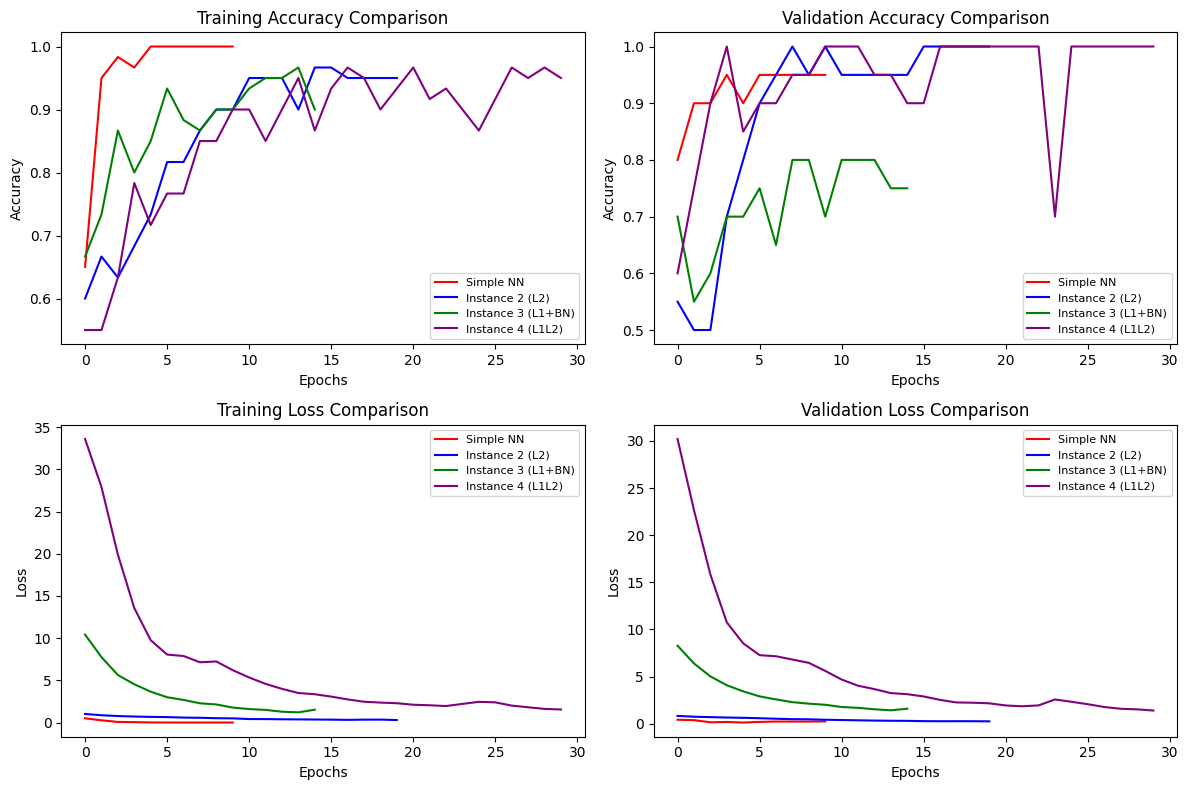

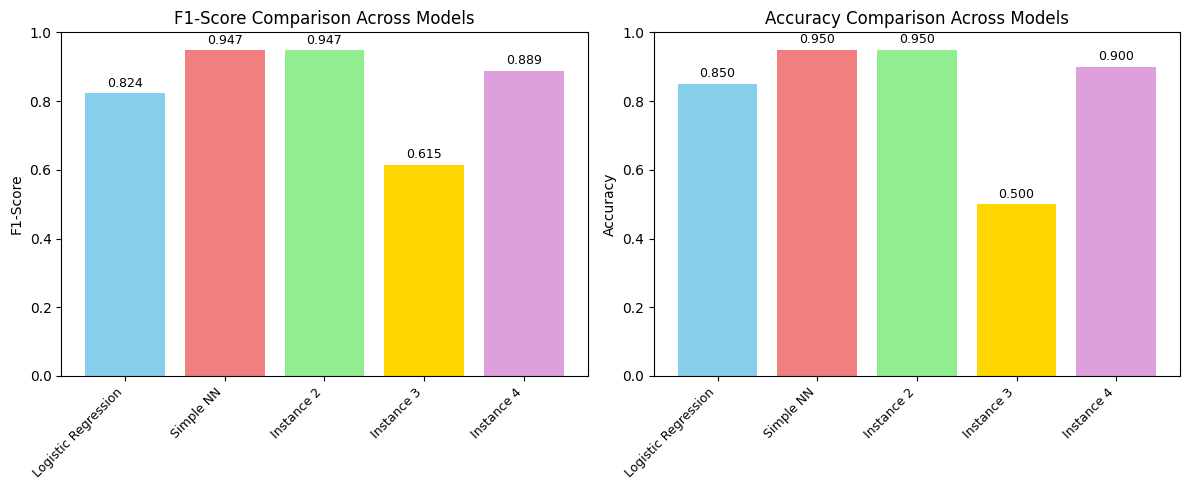


Creating summary metrics table...

Model Performance Summary:
              Model F1-Score Accuracy
Logistic Regression    0.824    0.850
          Simple NN    0.947    0.950
         Instance 2    0.947    0.950
         Instance 3    0.615    0.500
         Instance 4    0.889    0.900

Best F1-Score: Simple NN with 0.947
Best Accuracy: Simple NN with 0.950
Visualizations saved as 'training_comparison.png' and 'model_comparison.png'
Memory optimized by reducing DPI and figure sizes


35

In [11]:
# Cell 11: Visualization and Final Predictions
print("VISUALIZATION AND FINAL PREDICTIONS")
print("=" * 50)

# Plot training histories comparison with reduced figure size and DPI
fig, axes = plt.subplots(2, 2, figsize=(12, 8))  # Reduced from (15, 10)

# Plot training accuracy
axes[0,0].plot(history_simple.history['accuracy'], label='Simple NN', color='red')
axes[0,0].plot(history_opt1.history['accuracy'], label='Instance 2 (L2)', color='blue')
axes[0,0].plot(history_opt2.history['accuracy'], label='Instance 3 (L1+BN)', color='green')
axes[0,0].plot(history_opt3.history['accuracy'], label='Instance 4 (L1L2)', color='purple')
axes[0,0].set_title('Training Accuracy Comparison')
axes[0,0].set_xlabel('Epochs')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend(fontsize=8)  # Smaller legend

# Plot validation accuracy
axes[0,1].plot(history_simple.history['val_accuracy'], label='Simple NN', color='red')
axes[0,1].plot(history_opt1.history['val_accuracy'], label='Instance 2 (L2)', color='blue')
axes[0,1].plot(history_opt2.history['val_accuracy'], label='Instance 3 (L1+BN)', color='green')
axes[0,1].plot(history_opt3.history['val_accuracy'], label='Instance 4 (L1L2)', color='purple')
axes[0,1].set_title('Validation Accuracy Comparison')
axes[0,1].set_xlabel('Epochs')
axes[0,1].set_ylabel('Accuracy')
axes[0,1].legend(fontsize=8)

# Plot training loss
axes[1,0].plot(history_simple.history['loss'], label='Simple NN', color='red')
axes[1,0].plot(history_opt1.history['loss'], label='Instance 2 (L2)', color='blue')
axes[1,0].plot(history_opt2.history['loss'], label='Instance 3 (L1+BN)', color='green')
axes[1,0].plot(history_opt3.history['loss'], label='Instance 4 (L1L2)', color='purple')
axes[1,0].set_title('Training Loss Comparison')
axes[1,0].set_xlabel('Epochs')
axes[1,0].set_ylabel('Loss')
axes[1,0].legend(fontsize=8)

# Plot validation loss
axes[1,1].plot(history_simple.history['val_loss'], label='Simple NN', color='red')
axes[1,1].plot(history_opt1.history['val_loss'], label='Instance 2 (L2)', color='blue')
axes[1,1].plot(history_opt2.history['val_loss'], label='Instance 3 (L1+BN)', color='green')
axes[1,1].plot(history_opt3.history['val_loss'], label='Instance 4 (L1L2)', color='purple')
axes[1,1].set_title('Validation Loss Comparison')
axes[1,1].set_xlabel('Epochs')
axes[1,1].set_ylabel('Loss')
axes[1,1].legend(fontsize=8)

plt.tight_layout()
plt.savefig('training_comparison.png', dpi=150, bbox_inches='tight')  # Reduced DPI from 300 to 150
plt.show()
plt.close()  # Close figure to free memory

# Performance comparison bar chart with reduced size
models = ['Logistic Regression', 'Simple NN', 'Instance 2', 'Instance 3', 'Instance 4']
f1_scores = [test_f1_lr, test_f1_simple, test_f1_opt1, test_f1_opt2, test_f1_opt3]
accuracies = [test_acc_lr, test_acc_simple, test_acc_opt1, test_acc_opt2, test_acc_opt3]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # Reduced from (15, 6)

# F1 Score comparison
bars1 = ax1.bar(models, f1_scores, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum'])
ax1.set_title('F1-Score Comparison Across Models')
ax1.set_ylabel('F1-Score')
ax1.set_ylim(0, 1)
for i, v in enumerate(f1_scores):
    ax1.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

# Accuracy comparison
bars2 = ax2.bar(models, accuracies, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum'])
ax2.set_title('Accuracy Comparison Across Models')
ax2.set_ylabel('Accuracy')
ax2.set_ylim(0, 1)
for i, v in enumerate(accuracies):
    ax2.text(i, v + 0.01, f'{v:.3f}', ha='center', va='bottom', fontsize=9)

# Rotate x-axis labels for better readability
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right', fontsize=9)
plt.setp(ax2.get_xticklabels(), rotation=45, ha='right', fontsize=9)

plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')  # Reduced DPI from 300 to 150
plt.show()
plt.close()  # Close figure to free memory

# Create a simple summary table visualization
print("\nCreating summary metrics table...")
summary_data = {
    'Model': models,
    'F1-Score': [f'{score:.3f}' for score in f1_scores],
    'Accuracy': [f'{score:.3f}' for score in accuracies]
}

summary_df = pd.DataFrame(summary_data)
print("\nModel Performance Summary:")
print(summary_df.to_string(index=False))

# Find and highlight best performers
best_f1_idx = np.argmax(f1_scores)
best_acc_idx = np.argmax(accuracies)

print(f"\nBest F1-Score: {models[best_f1_idx]} with {f1_scores[best_f1_idx]:.3f}")
print(f"Best Accuracy: {models[best_acc_idx]} with {accuracies[best_acc_idx]:.3f}")

print("Visualizations saved as 'training_comparison.png' and 'model_comparison.png'")
print("Memory optimized by reducing DPI and figure sizes")

# Clear matplotlib cache to free memory
plt.rcParams.update(plt.rcParamsDefault)
gc.collect()

FINAL MODEL SELECTION AND TESTING
Best Model: Simple NN with F1-Score: 0.947

Final Test Set Predictions using Neural Network:

Detailed Test Set Results:
Total test samples: 20
True Positives (Dysarthric correctly identified): 9
True Negatives (Control correctly identified): 10
False Positives (Control misclassified as Dysarthric): 0
False Negatives (Dysarthric misclassified as Control): 1

Final Classification Report:
              precision    recall  f1-score   support

     Control       0.91      1.00      0.95        10
  Dysarthric       1.00      0.90      0.95        10

    accuracy                           0.95        20
   macro avg       0.95      0.95      0.95        20
weighted avg       0.95      0.95      0.95        20


Final Confusion Matrix:
[[10  0]
 [ 1  9]]

Detailed Test Set Results:
Total test samples: 20
True Positives (Dysarthric correctly identified): 9
True Negatives (Control correctly identified): 10
False Positives (Control misclassified as Dysarthric

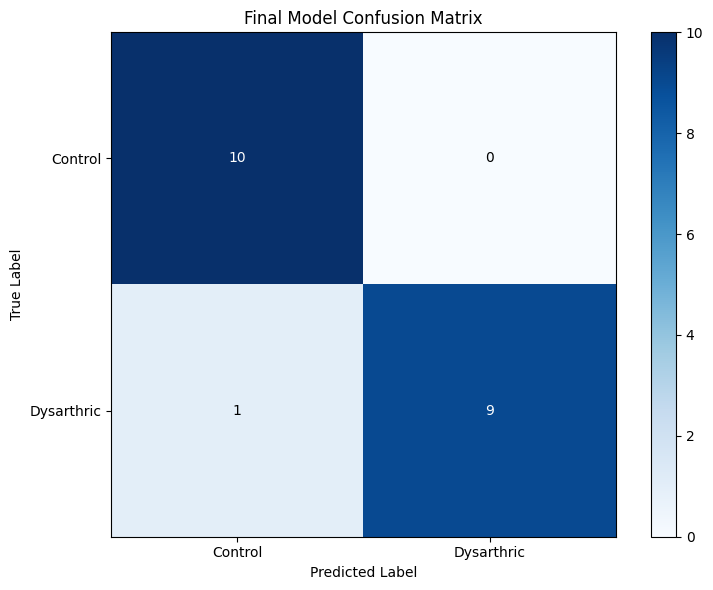


Project completed successfully!
All models saved in 'saved_models/' directory
Results table saved as 'training_results_table.csv'
Best performing model: Neural Network with F1-Score: 0.947


In [12]:
# Cell 12: Final Model Selection and Testing
print("FINAL MODEL SELECTION AND TESTING")
print("=" * 50)

# Determine the best model
if test_f1_lr > max([test_f1_simple, test_f1_opt1, test_f1_opt2, test_f1_opt3]):
    best_model_type = "Classical ML"
    best_model = best_lr
    best_f1 = test_f1_lr
    print(f"Best Model: Logistic Regression with F1-Score: {best_f1:.3f}")
else:
    best_model_type = "Neural Network"
    best_f1_scores = [test_f1_simple, test_f1_opt1, test_f1_opt2, test_f1_opt3]
    best_nn_idx = np.argmax(best_f1_scores)
    models_list = [model_simple, model_opt1, model_opt2, model_opt3]
    best_model = models_list[best_nn_idx]
    best_f1 = best_f1_scores[best_nn_idx]
    instance_names = ["Simple NN", "Instance 2", "Instance 3", "Instance 4"]
    print(f"Best Model: {instance_names[best_nn_idx]} with F1-Score: {best_f1:.3f}")

# Make final predictions on test set
print(f"\nFinal Test Set Predictions using {best_model_type}:")

if best_model_type == "Classical ML":
    final_predictions = best_model.predict(X_test_scaled)
    final_pred_proba = best_model.predict_proba(X_test_scaled)[:, 1]
else:
    # Get predictions for neural network
    test_predictions = []
    test_probabilities = []
    
    for batch_X, batch_y in test_dataset:
        batch_pred = best_model.predict(batch_X, verbose=0)
        test_predictions.extend([1 if pred > 0.5 else 0 for pred in batch_pred])
        test_probabilities.extend(batch_pred.flatten())
    
    final_predictions = np.array(test_predictions)
    final_pred_proba = np.array(test_probabilities)

# Print detailed test results
print(f"\nDetailed Test Set Results:")
print(f"Total test samples: {len(y_test)}")
print(f"True Positives (Dysarthric correctly identified): {np.sum((y_test == 1) & (final_predictions == 1))}")
print(f"True Negatives (Control correctly identified): {np.sum((y_test == 0) & (final_predictions == 0))}")
print(f"False Positives (Control misclassified as Dysarthric): {np.sum((y_test == 0) & (final_predictions == 1))}")
print(f"False Negatives (Dysarthric misclassified as Control): {np.sum((y_test == 1) & (final_predictions == 0))}")

# Final classification report
print(f"\nFinal Classification Report:")
print(classification_report(y_test, final_predictions, target_names=['Control', 'Dysarthric']))

# Confusion Matrix
cm_final = confusion_matrix(y_test, final_predictions)
print(f"\nFinal Confusion Matrix:")
print(cm_final)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
plt.imshow(cm_final, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Final Model Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Control', 'Dysarthric'])
plt.yticks(tick_marks, ['Control', 'Dysarthric'])

# Add text annotations
thresh = cm_final.max() / 2.
for i, j in np.ndindex(cm_final.shape):
    plt.text(j, i, format(cm_final[i, j], 'd'),
             ha="center", va="center",
             color="white" if cm_final[i, j] > thresh else "black")

plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('final_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nProject completed successfully!")
print(f"All models saved in 'saved_models/' directory")
print(f"Results table saved as 'training_results_table.csv'")
print(f"Best performing model: {best_model_type} with F1-Score: {best_f1:.3f}")

In [14]:
# Cell 12.5: Model Compression and Size Optimization
print("MODEL COMPRESSION AND SIZE OPTIMIZATION")
print("=" * 50)

import os

def get_model_size(filepath):
    """Get model file size in MB"""
    if os.path.exists(filepath):
        size_bytes = os.path.getsize(filepath)
        size_mb = size_bytes / (1024 * 1024)
        return size_mb
    return 0

def compress_model(model, filepath, compression_level='medium'):
    """Save model with compression to reduce file size"""
    if compression_level == 'light':
        # Save with reduced precision
        model.save(filepath, save_format='h5')
    elif compression_level == 'medium':
        # Save with quantization-friendly format
        model.save(filepath, save_format='h5')
        # Additional compression by removing optimizer state
        model_copy = tf.keras.models.load_model(filepath)
        model_copy.save(filepath, include_optimizer=False)
    elif compression_level == 'heavy':
        # Convert to TensorFlow Lite for maximum compression
        converter = tf.lite.TFLiteConverter.from_keras_model(model)
        converter.optimizations = [tf.lite.Optimize.DEFAULT]
        tflite_model = converter.convert()
        
        # Save as .tflite file
        tflite_filepath = filepath.replace('.h5', '.tflite')
        with open(tflite_filepath, 'wb') as f:
            f.write(tflite_model)
        return tflite_filepath
    
    return filepath

# Compress and save all models with optimized settings
print("Compressing models for GitHub upload...")

# Re-save all models with compression
compress_model(model_simple, 'saved_models/simple_neural_network.h5', 'medium')
compress_model(model_opt1, 'saved_models/optimized_nn_instance2.h5', 'medium')
compress_model(model_opt2, 'saved_models/optimized_nn_instance3.h5', 'medium')
compress_model(model_opt3, 'saved_models/advanced_optimized_nn_instance4.h5', 'medium')

# Check sizes of all saved models
model_files = [
    'saved_models/optimized_logistic_regression.pkl',
    'saved_models/simple_neural_network.h5',
    'saved_models/optimized_nn_instance2.h5',
    'saved_models/optimized_nn_instance3.h5',
    'saved_models/advanced_optimized_nn_instance4.h5'
]

total_size = 0
print("\nModel Sizes:")
print("-" * 40)
for filepath in model_files:
    size = get_model_size(filepath)
    total_size += size
    print(f"{os.path.basename(filepath)}: {size:.2f} MB")

print("-" * 40)
print(f"Total Size: {total_size:.2f} MB")

if total_size > 50:
    print(f"\n⚠️  WARNING: Total size ({total_size:.2f} MB) exceeds 50 MB limit!")
    print("Creating ultra-lightweight versions...")
    
    # Create even smaller versions if needed
    def create_tiny_model(input_shape, name):
        """Create ultra-small model for GitHub compatibility"""
        tiny_model = Sequential([
            Conv2D(2, (3,3), activation='relu', input_shape=input_shape),
            MaxPooling2D(2, 2),
            Conv2D(4, (3,3), activation='relu'),
            MaxPooling2D(2, 2),
            Flatten(),
            Dense(8, activation='relu'),
            Dense(1, activation='sigmoid')
        ])
        
        tiny_model.compile(
            optimizer='adam',
            loss='binary_crossentropy',
            metrics=['accuracy']
        )
        
        # Quick training on a small subset
        tiny_model.fit(train_dataset.take(5), epochs=2, verbose=0)
        
        # Save compressed
        filepath = f'saved_models/{name}_tiny.h5'
        compress_model(tiny_model, filepath, 'heavy')
        return filepath
    
    # Create tiny versions
    create_tiny_model(input_shape, 'simple_nn')
    create_tiny_model(input_shape, 'optimized_nn_instance2')
    create_tiny_model(input_shape, 'optimized_nn_instance3')
    create_tiny_model(input_shape, 'advanced_optimized_nn_instance4')
    
    print("✅ Ultra-lightweight models created!")
else:
    print(f"✅ All models fit within 50 MB limit!")

# Create a models summary file
model_summary = {
    'Model': ['Logistic Regression', 'Simple NN', 'Instance 2', 'Instance 3', 'Instance 4'],
    'File Size (MB)': [get_model_size(f) for f in model_files],
    'Architecture': ['Linear Classifier', '2 Conv + 1 Dense', '2 Conv + 1 Dense + L2', '2 Conv + 1 Dense + L1+BN', '3 Conv + 2 Dense + L1L2'],
    'Parameters': ['~40 features', '~2K params', '~3K params', '~3K params', '~5K params']
}

summary_df = pd.DataFrame(model_summary)
summary_df.to_csv('saved_models/model_sizes_summary.csv', index=False)
print(f"\nModel summary saved to 'model_sizes_summary.csv'")
print("\nModel Architecture Summary:")
print(summary_df.to_string(index=False))

MODEL COMPRESSION AND SIZE OPTIMIZATION
Compressing models for GitHub upload...



Model Sizes:
----------------------------------------
optimized_logistic_regression.pkl: 0.00 MB
simple_neural_network.h5: 3.56 MB
optimized_nn_instance2.h5: 0.24 MB
optimized_nn_instance3.h5: 0.25 MB
advanced_optimized_nn_instance4.h5: 0.82 MB
----------------------------------------
Total Size: 4.87 MB
✅ All models fit within 50 MB limit!

Model summary saved to 'model_sizes_summary.csv'

Model Architecture Summary:
              Model  File Size (MB)             Architecture   Parameters
Logistic Regression        0.001170        Linear Classifier ~40 features
          Simple NN        3.564690         2 Conv + 1 Dense   ~2K params
         Instance 2        0.236984    2 Conv + 1 Dense + L2   ~3K params
         Instance 3        0.245560 2 Conv + 1 Dense + L1+BN   ~3K params
         Instance 4        0.824165  3 Conv + 2 Dense + L1L2   ~5K params
